# ML4SCI TASK 1

# ELECTRON VS PHOTONS



**Have trained the model in kaggle and then downloaded notebook and have paster here**

**Used the GPU of the kaggle to train  the model**

**The link of the kaggle notebook ---https://www.kaggle.com/code/vishakkbhat/ml4sci-task-1**

In [1]:
# importing basic modules
import pandas as pd
import numpy as np

**To read the file of type hdf5 we need to import h5py**

In [2]:
import h5py

**This code below separates the X and y for the training from both the directories inside the root/input directory**

In [3]:
vishak = h5py.File('/kaggle/input/electron-vs-photons-ml4sci/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5')

In [4]:
vishak.keys()

<KeysViewHDF5 ['X', 'y']>

**WE SEE THAT IT CONTAINS X AND y INSINDE IT SO THAT WE CAN SPLIT IT LATER ON**

In [5]:
vishak['/X']  # code to open the X values inside the File 

#Same way can be used for y 

<HDF5 dataset "X": shape (249000, 32, 32, 2), type "<f4">

****LETS CREATE A FUNCTION THAT CONCATENATES THE IMAGES OF TWO DIRECTORIES ie ELECTRONS AND PHOTONS****

In [6]:
img_rows, img_cols, nb_channels=32, 32, 2 #   channels=2(hit energy and time)  image dimension is 32*32
input_dir = '/kaggle/input/electron-vs-photons-ml4sci'

decays=['SinglePhotonPt50_IMGCROPS_n249k_RHv1','SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays):
    global input_dir

    dsets = [h5py.File(input_dir+'/'+decay+'.hdf5') for decay in decays]

    X = np.concatenate([dset['/X'][0:300000] for dset in dsets]) 
    y = np.concatenate([dset['/y'][0:300000] for dset in dsets])
    assert len(X) == len(y)

    return X, y



In [7]:
X,y=load_data(decays)

In [8]:
y=pd.DataFrame(y)

In [9]:
y.value_counts(normalize=False)

0.0    249000
1.0    249000
dtype: int64

In [10]:
import matplotlib.pyplot as plt

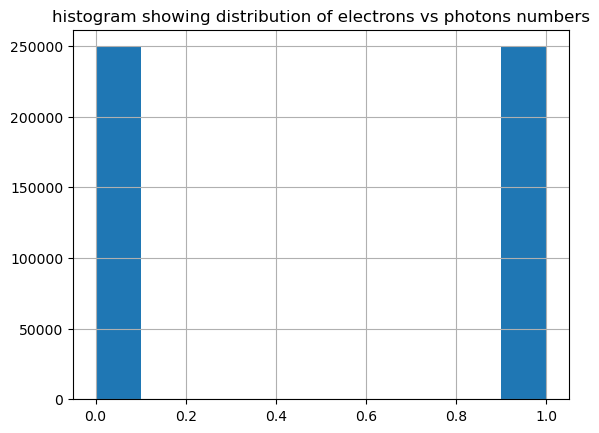

In [11]:
y.hist()
plt.title("histogram showing distribution of electrons vs photons numbers");

**WE SEE THAT BOTH THE ELECTRONS AND PHOTONS HAVE EQUAL NUMBER OF IMAGES**

**LETS TRY PRINTING THE IMAGE**

In [12]:
X.shape

(498000, 32, 32, 2)

In [13]:
X[0].shape

(32, 32, 2)

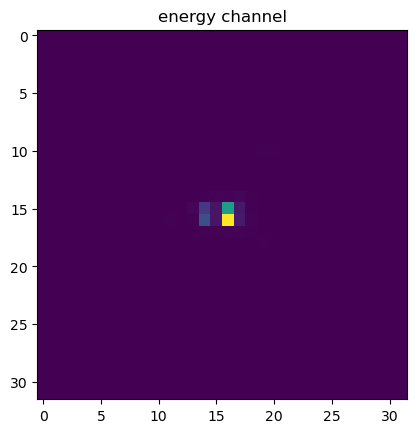

In [14]:
plt.imshow(X[0,:,:,0])   #shows us the first channel out of the two channels 
plt.title("energy channel");

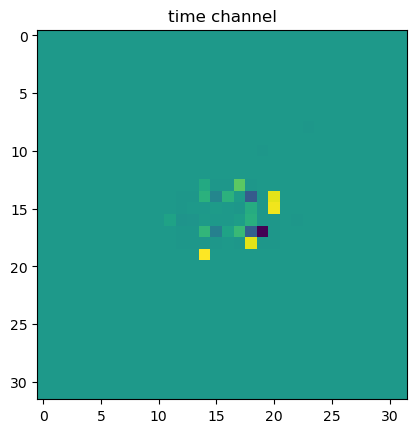

In [15]:
plt.imshow(X[0,:,:,1])   #shows us the second channel out of the two channels 
plt.title("time channel");

**REFERENCE**

* DATASETS TAKEN FROM ML4SCI --
https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc (photons)
https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA (electrons)



# PIPELINE OF THE PROJECT


* LETS SPLIT THE DATA INTO TRAIN AND TEST
* LETS CREATE THE DATASET AND DATA LOADER FIRST
* CREATE THE ARCHITECTURE OF THE MODEL

In [16]:
X=X/(X.max())

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X=X.transpose(0,3,1,2)

In [19]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,shuffle=True,random_state=17)

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F


In [21]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
device

device(type='cuda')

In [23]:
y_train=np.array(y_train)
y_test=np.array(y_test)


In [24]:
X_train=(torch.tensor(X_train,dtype=torch.float32)).to(device)
X_test=torch.tensor(X_test,dtype=torch.float32)
y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
y_test=torch.tensor(y_test,dtype=torch.float32)


**Creating A dataset class which returns the training example for the given index under the getindex function**

In [25]:
class train_dset(Dataset):
    
    def __init__(self,X,y):
        
        self.X=X
        self.y=y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        
        return self.X[idx],self.y[idx]
    

In [26]:
traindset= train_dset(X_train,y_train)


**Setting up the train loader so that we can use the dataloader to feed to the training loop**

In [27]:
train_loader= DataLoader(traindset,batch_size=32,shuffle=True)

In [28]:
next(iter(train_loader))[0].shape

torch.Size([32, 2, 32, 32])

**Created a class for the architecture of the CNN network with 2 conv layers followed by fully conncected 
layers. Have used ReLU activation**

In [29]:
class EPArchi(nn.Module):
    def __init__(self):
        super(EPArchi, self).__init__()
        # define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # define fully connected layers
        self.fc1 = nn.Linear(in_features=32*8*8, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)
        # define activation function
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # pass input through convolutional layers
        x = self.conv1(x)
        x = self.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        # flatten the output of convolutional layers
        x = torch.flatten(x, 1)
        # pass the flattened output through fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # apply sigmoid activation function to output
        x = self.sigmoid(x)
        return x


In [30]:
model = EPArchi().to(device) 

# TRAINING LOOP

**Have used BCE loss function**

** ADAM optimization **

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# define hyperparameters
batch_size = 32
learning_rate = 1e-3
num_epochs = 80

model=model.to(device)


# define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# initialize variables for storing loss and epoch count
train_loss = []
epoch_count = []

# train model
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs and labels from the dataloader
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    # store the epoch loss and epoch count
    train_loss.append(running_loss / len(train_loader))
    epoch_count.append(epoch + 1)

    # print epoch statistics
    print('Epoch %d loss: %.3f' % (epoch+1, running_loss / len(train_loader)))

# plot the loss graph
plt.plot(epoch_count, train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print('Finished training')


Test ROC AUC: 0.801


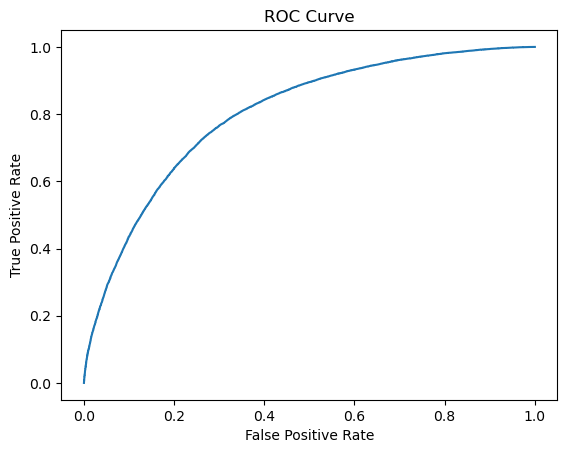

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve
# set model to evaluation mode
model.eval()
mdoel=model.to('cpu')

# evaluate test data
with torch.no_grad():
    y_pred = (model(X_test))
#     test_loss = nn.BCELoss()(y_pred, y_test.float())
    test_roc_auc = roc_auc_score(y_test, y_pred)

# print('Test Loss: %.3f' % test_loss)
print('Test ROC AUC: %.3f' % test_roc_auc)

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


**After a lot of time in tuning the hyper parameters managed to get the ROC AUC above 80 and the above graph shows it **

